# Model $\mathcal{E}$
This RMI model is comprised of X stages, layed out as follows:

* Stage 1 : Linear Regressor, with ReLU activation functions
* Stage 2 : Linear Regressor, with ReLU activation functions

Each component sub-model in this RMI model is trained for 5 epochs.

<img alt="ModelDiagram" src="modeldiagram.png" />

## Experiment 1 : Bimodal Normal Distribtution (60k)

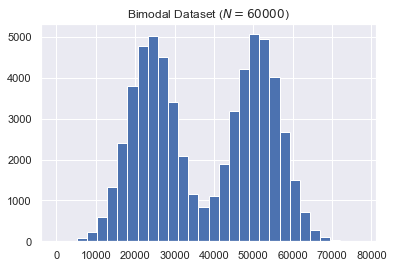

In [16]:
import pickle
import numpy as np

with open("bimodal60k.data", "rb") as f:
    dataset = pickle.load(f)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.hist(dataset[0], bins=30)
plt.title(f"Bimodal Dataset ($N = {len(dataset[0])}$)")
plt.show()

First, we compare the RMI model build time versus a B-Tree's build time using python's `time` module.

In [17]:
# RMI Build Time
from time import time
from model import build_fit_rmi_model, predict_rmi_model, MaxAbsoluteError, keras

n_epochs=5
adam = keras.optimizers.Adam(learning_rate=5e-2)
mae, aae = MaxAbsoluteError(), keras.metrics.MeanAbsoluteError()
t0 = time()
model = build_fit_rmi_model(dataset, stages=(1,16), n_layers=0, n_neurons=32, n_epochs=n_epochs, initializer='identity', verbose=False, optimizer=adam, loss='mse', metrics=[mae, aae])
t1 = time()
rmi_buildtime = t1-t0
print(f"RMI Build Time = {rmi_buildtime} sec")

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

FITTING RMI MODEL WITH BATCH SIZE 64


(S2, M16)  Finished Epoch #5  MaxAE 6514.609375 Mean AE 1404.944580078125:  40%|███▌     | 2/5 [00:17<00:25,  8.65s/it]

RMI Build Time = 17.293230533599854 sec


In [18]:
from BTrees.IIBTree import IIBTree
t0 = time()
btree = IIBTree()
btree.update({int(dataset[1,r,0]):int(dataset[0,r,0]) for r in range(len(dataset[0]))})
t1 = time()
btree_buildtime = t1-t0
print(f"BTree Build Time = {btree_buildtime} sec")

BTree Build Time = 0.04799771308898926 sec


-----------
Now, we compute the average prediction time over all valid queries for the RMI then the B-Tree. While predicting, we also compute the number of array accesses being made by the algorithm in querying for comparison with the B-Tree.

In [74]:
rmi_array_accesses = 0

In [78]:
from tqdm import tqdm

def exponential_search(data, prediction_func, index_func, data_length):
    def our_bisect_left(a, x, lo=0, hi=None, *, key=None):
        """
        Return the index where to insert item x in list a, assuming a is sorted.
        The return value i is such that all e in a[:i] have e < x, and all e in
        a[i:] have e >= x.  So if x already appears in the list, a.insert(i, x) will
        insert just before the leftmost x already there.
        Optional args lo (default 0) and hi (default len(a)) bound the
        slice of a to be searched.
        """
        if lo < 0:
            raise ValueError('lo must be non-negative')
        if hi is None:
            hi = data_length
        # Note, the comparison uses "<" to match the
        # __lt__() logic in list.sort() and in heapq.
        if key is None:
            while lo < hi:
                mid = (lo + hi) // 2
                if index_func(a, mid) < x:
                    lo = mid + 1
                else:
                    hi = mid
        else:
            while lo < hi:
                mid = (lo + hi) // 2
                if key(index_func(a ,mid)) < x:
                    lo = mid + 1
                else:
                    hi = mid
        return lo
    
    def inner(x):
        ly = yhat = ry = prediction_func(x)

        if index_func(data, yhat) > x:
            i = 1
            while ly > 0 and index_func(data, ly) > x:
                ly = yhat - i
                i *= 2
            if ly < 0:
                ly = 0
        elif index_func(data, yhat) < x:
            i = 1
            while ry < data_length and index_func(data, ry) < x:
                ry = yhat + i
                i *= 2
            if ry >= data_length:
                ry = data_length - 1
        yhat = our_bisect_left(data, x, ly, ry)
        return yhat if index_func(data, yhat) == x else -1
    return inner

rmi_array_accesses = 0

def rmi_test_index(data, i):
    global rmi_array_accesses
    rmi_array_accesses += 1
    return data[1,i,0]

N = dataset.shape[1]
dataset = dataset.astype(int)
# Qi = np.random.choice(range(dataset.shape[1]), size=N).tolist()
Qi = list(range(dataset.shape[1]))
Q = dataset[0,Qi,0].astype(int)
Yt = dataset[1,Qi,0].astype(int)
pred_func = lambda x: predict_rmi_model(model, x.reshape(1,1,1), maxind=dataset.shape[1]).astype(int)[0]
index_func = lambda d,i: rmi_test_index(d, i)
query_search = exponential_search(dataset, pred_func, index_func, N)
t0 = time()
pbar = tqdm(range(N))
for i in pbar:
    q = Q[i]
    yt = Yt[i]
    yh = query_search(q)
    if yh < 0:
        print(f"Negative Index for Query: {q}")
    running_avg = rmi_array_accesses / float(max(1, i))
    pbar.set_description(f"Avg. Array Accesses ~ {running_avg}")
t1 = time()
rmi_querytime = t1-t0
print(f"RMI Query Time: {rmi_querytime / float(N)}")

Avg. Array Accesses ~ 32.41929541210317:  66%|███████████████████████            | 39627/60000 [49:13<25:18, 13.42it/s]


KeyboardInterrupt: 

In [ ]:
t0 = time()
for i in range(N):
    q = Q[i]
    btree.get(q)
t1 = time()
btree_querytime = t1-t0
print(f"BTree Query Time: {btree_querytime / float(N)}")